# Generate fun images of your dog

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

---

---
In this demo notebook, we demonstrate how to use the JumpStart APIs to fine-tune the stable diffusion model to your dog images dataset and deploy the fine-tuned model. To execute this notebook, you will need a collection of dog images. You may upload as little as five images to your local folder and run the notebook.

Note: This notebook contains a very simplified version of the features available for Stable Diffusion in JumpStart. Please refer to the [Introduction to JumpStart - Text to Image](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/Amazon_JumpStart_Text_To_Image.ipynb) notebook for a more comprehensive list of Stable Diffusion features available in JumpStart.

Note: To run this notebook, you would need `ml.g4dn.2xlarge` instance type for training and for inference.

---

1. [Set Up](#1.-Set-Up)

3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#3.2.-Set-Training-parameters)
    * [Start Training](#3.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.4.-Deploy-and-run-inference-on-the-fine-tuned-model)


## 1. Set Up
---
Set up credentials and create a local training directory where you will upload your training images.

---

In [2]:
import botocore
import sagemaker, boto3, json
from sagemaker import get_execution_role
import os


aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

# If uploading to a different folder, change this variable.
local_training_dataset_folder = "training_images"
if not os.path.exists(local_training_dataset_folder):
    os.mkdir(local_training_dataset_folder)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


---

### Please upload images of your dog to `training_images` local folder and change use_local_images=True.

---

In [3]:
use_local_images = False  # If False, notebook will use the example dataset provided by JumpStart


if not use_local_images:
    # Downloading example dog images from JumpStart S3 bucket

    s3_resource = boto3.resource("s3")
    bucket = s3_resource.Bucket(f"jumpstart-cache-prod-{aws_region}")
    for obj in bucket.objects.filter(Prefix="training-datasets/dogs_sd_finetuning/"):
        bucket.download_file(
            obj.key, os.path.join(local_training_dataset_folder, obj.key.split("/")[-1])
        )  # save to same path

In [4]:
# Instance prompt refers to the textual description of images in the training dataset. Try to be as detailed and as accurate as possible.
# In addition to the textual description, we also need a tag (Doppler in the example below).

instance_prompt = "A photo of a Doppler dog"

In [5]:
# Instance prompt is fed into the training script via dataset_info.json present in the training folder. Here, we write that file.
import os
import json

with open(os.path.join(local_training_dataset_folder, "dataset_info.json"), "w") as f:
    f.write(json.dumps({"instance_prompt": instance_prompt}))

### Upload dataset to S3

---
Next, we upload the dataset to S3 bucket. If the bucket does not exists, we create a new bucket. 

---

In [6]:
mySession = boto3.session.Session()
AwsRegion = mySession.region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

training_bucket = f"stable-diffusion-jumpstart-{AwsRegion}-{account_id}"

---

If you have an existing bucket you would like to use, please replace the `training_bucket` with your bucket in the cell above and avoid executing the following cell.

---

In [7]:
assets_bucket = f"jumpstart-cache-prod-{AwsRegion}"


s3 = boto3.client("s3")
s3.download_file(
    f"jumpstart-cache-prod-{AwsRegion}",
    "ai_services_assets/custom_labels/cl_jumpstart_ic_notebook_utils.py",
    "utils.py",
)


from utils import create_bucket_if_not_exists

create_bucket_if_not_exists(training_bucket)

Created s3.Bucket(name='stable-diffusion-jumpstart-us-west-2-160817128410')


---

Next we upload the training datasets (images and `dataset_info.json`) to the S3 bucket.

---


In [8]:
train_s3_path = f"s3://{training_bucket}/custom_dog_stable_diffusion_dataset/"

!aws s3 cp --recursive $local_training_dataset_folder $train_s3_path

upload: training_images/IMG_0861.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0861.jpg
upload: training_images/IMG_0862.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0862.jpg
upload: training_images/IMG_0856.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0856.jpg
upload: training_images/IMG_0872.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0872.jpg
upload: training_images/IMG_0866.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0866.jpg
upload: training_images/IMG_0870.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0870.jpg
upload: training_images/IMG_0874.jpg to s3://stable-diffusion-jumpstart-us-west-2-160817128410/custom_dog_stable_diffusion_dataset/IMG_0

## 2. Fine-tune the pre-trained model on a custom dataset



### 2.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [9]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "1.*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = "ml.g4dn.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'model-txt2img-stabilityai-stable-diffusion-v2-1-base' with wildcard version identifier '1.*'. You can pin to version '1.1.3' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


### 2.2. Set Training parameters

---
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path: This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct `train_image_uri`.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [10]:
output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [12]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values. This controls the duration of the training and the quality of the output.
# If max_steps is too small, training will be fast but the the model will not be able to generate custom images for your usecase.
# If max_steps is too large, training will be very slow.
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


### 2.3. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

In [13]:
%time
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": train_s3_path}, logs=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: jumpstart-example-model-txt2img-stabili-2024-04-02-14-03-29-538


2024-04-02 14:03:29 Starting - Starting the training job...
2024-04-02 14:03:44 Starting - Preparing the instances for training...
2024-04-02 14:04:18 Downloading - Downloading input data...............
2024-04-02 14:06:33 Downloading - Downloading the training image...
2024-04-02 14:07:19 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-04-02 14:07:42,169 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-04-02 14:07:42,202 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-04-02 14:07:42,205 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-04-02 14:07:43,689 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerate/acce

### 2.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We start by retrieving the JumpStart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `sd_estimator` that we have fine-tuned.

---

In [14]:
%time

inference_instance_type = "ml.g4dn.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-160817128410/jumpstart-example-sd-training/output/jumpstart-example-model-txt2img-stabili-2024-04-02-14-03-29-538/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-160817128410/sagemaker-jumpstart-2024-04-02-14-20-56-020/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-04-02-14-20-56-020
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-model-txt2img-stab-2024-04-02-14-20-56-020
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-model-txt2img-stab-2024-04-02-14-20-56-020


---------!

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = json.dumps(text).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
Next, we query the finetuned model, parse the response and display the generated image.  Please execute the following cells.

---

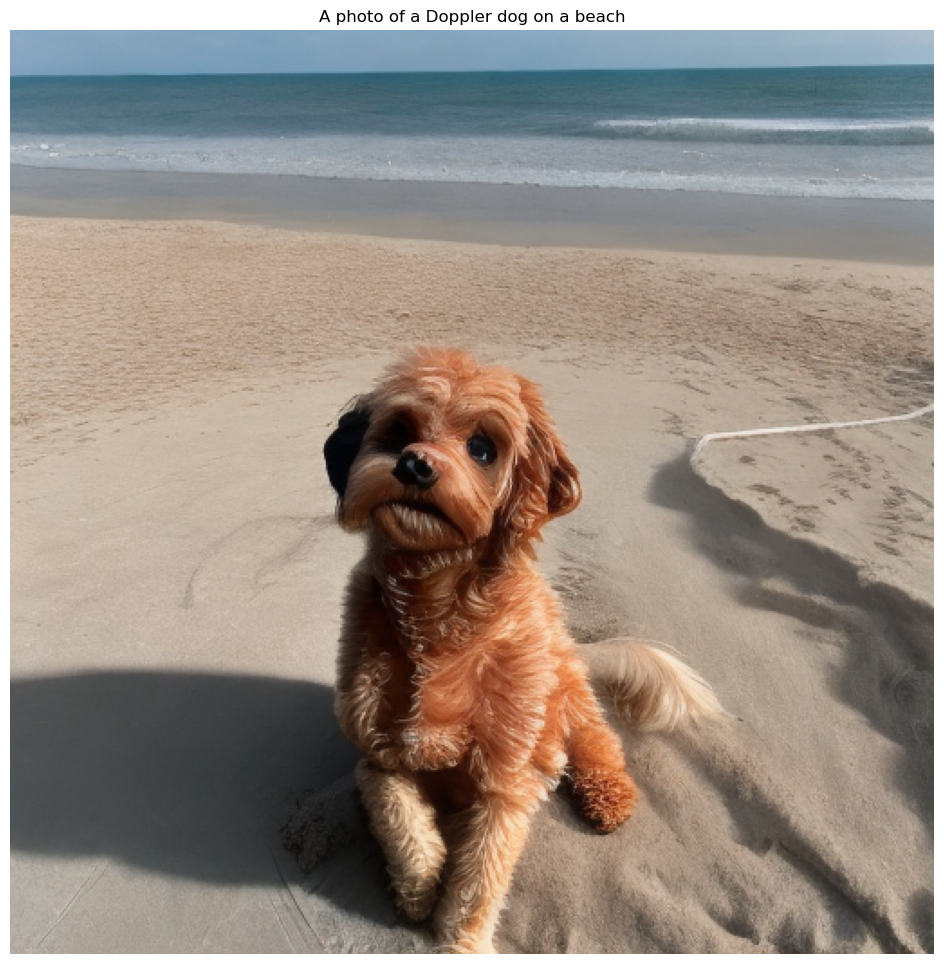

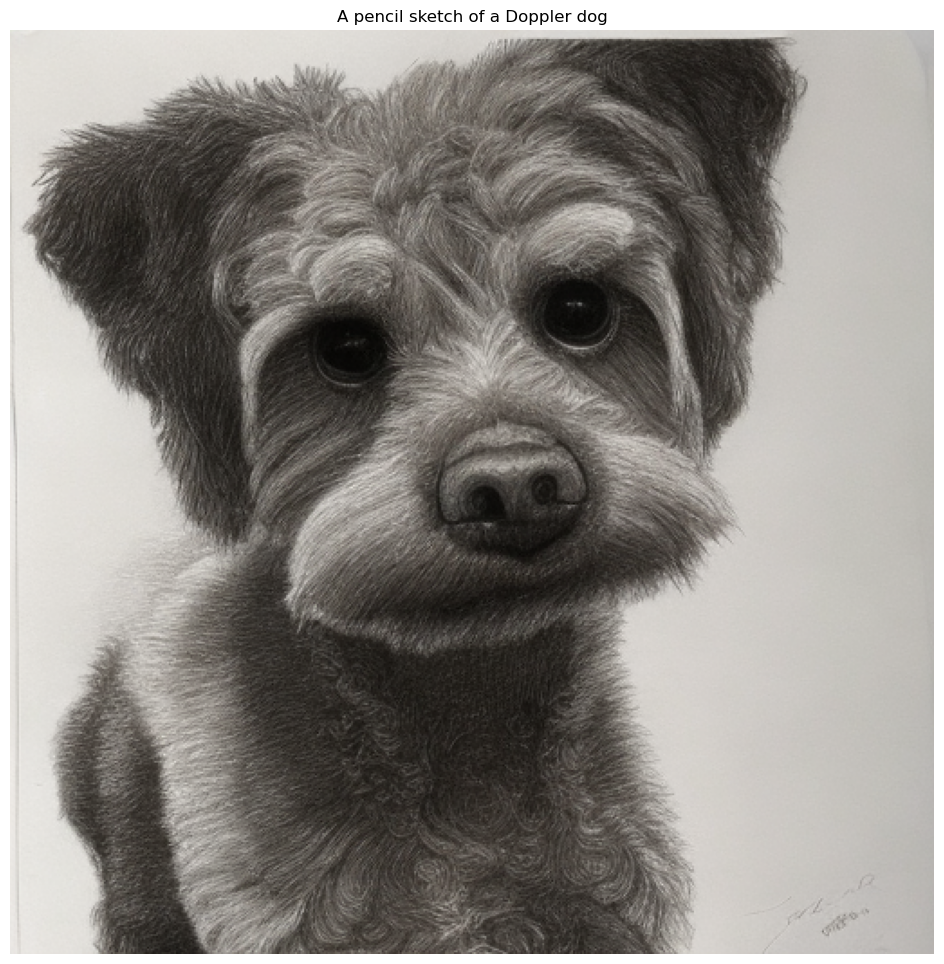

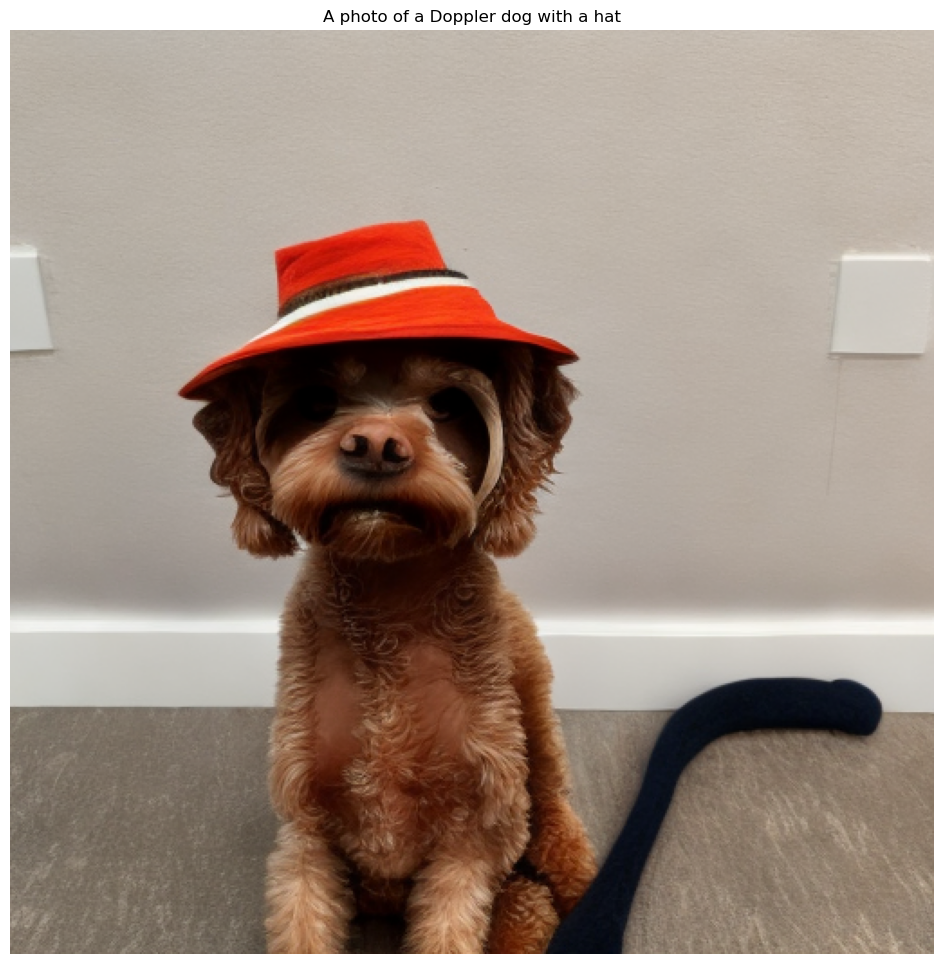

In [16]:
all_prompts = [
    "A photo of a Doppler dog on a beach",
    "A pencil sketch of a Doppler dog",
    "A photo of a Doppler dog with a hat",
]
for prompt in all_prompts:
    query_response = query(finetuned_predictor, prompt)
    img, _ = parse_response(query_response)
    display_img_and_prompt(img, prompt)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

## Conclusion
---
In this notebook, we saw a simple workflow on how you can fine-tune the stable diffusion text-to-image model on your dataset with a small set of images. You can adapt the notebook your dataset by uploading images of the desired subject and changing the prompts. For instance, if you would like to generate images of your cat, please upload cat images in the first step and change dog to cat in the `instance_prompt` before training and while inocking endpoint with fine-tuned model.

This notebook contains a barebone code to train and deploy the stable diffusion model. Please refer to the [Introduction to JumpStart - Text to Image](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/Amazon_JumpStart_Text_To_Image.ipynb) for additional features such as (i) How to deploy a pre-trained Stable Diffusion model (more than 80 available in JumpStart), (ii) How to set parameters such as num_steps, guidance scale during inference, (iii) Prompt Engineering, (iv) How to set training related parameters.

----

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|jumpstart_text_to_image|custom_dog_image_generator.ipynb)
